- **Date:** 2019-5-22
- **Author:** Zhanyuan Zhang
- **Purpose:** 
    1. This notebook visualizes image preprocessing (padding).
    1. Define some helper functions.
    1. Do sanity check of model and try reproducing the results in the [paper](https://openreview.net/pdf?id=SkfMWhAqYQ)
- **Conclusion:** Seems like there are some problem in prediction by patches.

In [0]:
%load_ext autoreload
%autoreload 2

In [0]:
from bagnets.utils import plot_heatmap, generate_heatmap_pytorch
from foolbox.utils import samples
import bagnets.pytorch
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import numpy as np
import time
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
if use_cuda:
    print(torch.cuda.get_device_name(0))

Tesla K80


In [0]:
# load pretrained model
pytorch_model = bagnets.pytorch.bagnet33(pretrained=True).to(device)

### 0. Define some helper functions

In [0]:
# Reference: https://github.com/wielandbrendel/bag-of-local-features-models/blob/master/bagnets/utils.py

def pad_image(image, patchsize):
    _, c, x, y = image.shape
    padded_image = np.zeros((c, x + patchsize - 1, y + patchsize - 1))
    padded_image[:, (patchsize-1)//2 : (patchsize-1)//2 + x, (patchsize-1)//2 : (patchsize-1)//2 + y] = image[0]
    return padded_image[None].astype(np.float32)

def convert2channel_last(image):
    return image.transpose([1, 2, 0])

def imagenet_preprocess(image):
    # preprocess sample image before training
    image = image / 255.
    image -= np.array([0.485, 0.456, 0.406])[:, None, None]
    image /= np.array([0.229, 0.224, 0.225])[:, None, None]
    return image

def extract_patches(image, patchsize):
    patches = image.permute(0, 2, 3, 1)
    patches = patches.unfold(1, patchsize, 1).unfold(2, patchsize, 1)
    patches = patches.contiguous().view((-1, 3, patchsize, patchsize))
    return patches

def bagnet_predict(bagnet, patches, device, batch_size=1000, return_class=True):
    with torch.no_grad():
        cum_logits = torch.zeros(1000).to(device) # ImageNet has 1000 classes
        for batch_patches in torch.split(patches, batch_size):
            logits = bagnet(batch_patches)
            
            sum_logits = torch.sum(logits, dim=0)
            cum_logits += sum_logits
        p = F.softmax(cum_logits/(244*244), dim=0)
        if return_class:
            return torch.argmax(p).item()
        else:
            return p.cpu().numpy()

def compare_heatmap(bagnet, patches, gt, target, original, batch_size=1000):
    with torch.no_grad():
        gt_logits_list, target_logits_list = [], []
        for batch_patches in torch.split(patches, batch_size):
            logits = bagnet(batch_patches)
            gt_logits = logits[:, gt][:, 0]
            target_logits = logits[:, target][:, 0]
            gt_logits_list.append(gt_logits.data.cpu().numpy().copy())
            target_logits_list.append(target_logits.data.cpu().numpy().copy())
        gt_logits = np.hstack(gt_logits_list)
        target_logits = np.hstack(target_logits_list)
        gt_heatmap = gt_logits.reshape((224, 224))
        target_heatmap = target_logits.reshape((224, 224))
    fig = plt.figure(figsize=(8, 4))
    original_image = original[0].transpose([1, 2, 0])
    ax = plt.subplot(131)
    ax.set_title('original')
    plt.imshow(original_image / 255.)
    plt.axis('off')
    
    ax = plt.subplot(132)
    ax.set_title('ground true class')
    plot_heatmap(gt_heatmap, original_image, ax, dilation=0.5, percentile=99, alpha=0.25)
    plt.axis('off')
    
    ax = plt.subplot(133)
    ax.set_title('target class')
    plot_heatmap(target_heatmap, original_image, ax, dilation=0.5, percentile=99, alpha=0.25)
    plt.axis('off')
    plt.show()

### 1. Visualize the padding

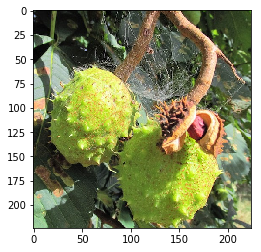

In [0]:
image, label = samples(dataset='imagenet', index=163, batchsize=1, shape=(224, 224), data_format='channels_first')
original_image = convert2channel_last(image[0])
plt.imshow(original_image/255.0)

The preprocessing shifts and scale pixel values to [-1, 1]. Since the library clips the pixel values from 0 to 1, the image after preprocessing looks different.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


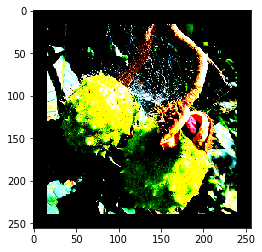

In [0]:
patchsize = 33
sample = imagenet_preprocess(image)
padded_sample = pad_image(sample, patchsize)
plt.imshow(convert2channel_last(padded_sample[0]))

### 2. Some shapes in model

If patch size is 33-by-33, then we can extract 50176 patches from a 224-by-224 image.

In [0]:
input = torch.from_numpy(padded_sample).to(device)
patches = extract_patches(input, patchsize)
patches.shape

torch.Size([50176, 3, 33, 33])

### 3. Sanity check on model prediction

Prediction on one image takes around 26 ~ 30 seconds.

In [0]:
tic = time.time()
pred = bagnet_predict(pytorch_model, patches, device, return_class=True)
tac = time.time()
print('prediction: {}'.format(pred))
print('time: {}s'.format(tac-tic))
print('true: {}'.format(label.item()))

prediction: 463
time: 25.869900703430176s
true: 990


In [0]:
np.random.seed(888)
patchsize = 33
pred_list, label_list = [], []
for idx in np.random.choice(np.arange(20), size=10):
    image, label = samples(dataset='imagenet', index=idx, batchsize=1, shape=(224, 224), data_format='channels_first')
    label_list.append(label)
    sample = imagenet_preprocess(image)
    padded_sample = pad_image(sample, patchsize)
    input = torch.from_numpy(padded_sample).to(device)
    patches = extract_patches(input, patchsize)
    pred = bagnet_predict(pytorch_model, patches, device, return_class=True)
    pred_list.append(pred)
    print('Same: {}, true label: {}, prediction: {}'.format(label == pred, label, pred))

Same: [False], true label: [471], prediction: 463
Same: [False], true label: [99], prediction: 463
Same: [False], true label: [305], prediction: 463
Same: [False], true label: [609], prediction: 463
Same: [False], true label: [129], prediction: 463
Same: [False], true label: [471], prediction: 463
Same: [False], true label: [22], prediction: 463
Same: [False], true label: [251], prediction: 463
Same: [False], true label: [741], prediction: 463
Same: [False], true label: [243], prediction: 463


**TODO**: Figure out the reason why the pretrained model always return class 463.

Inspect the heatmap of ground truth class and the heatmap of class 463.

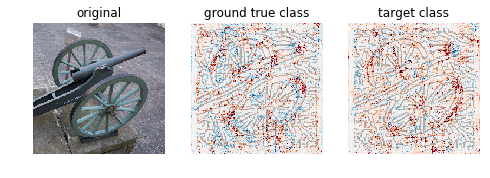

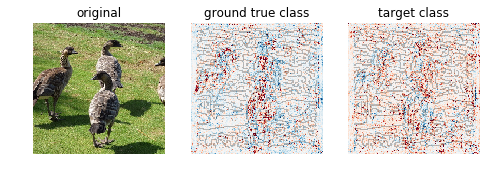

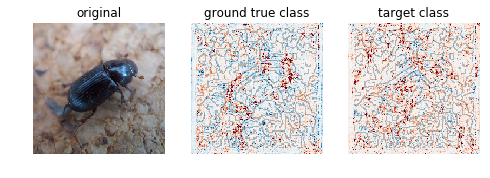

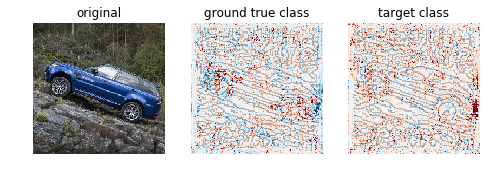

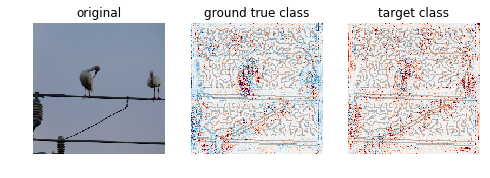

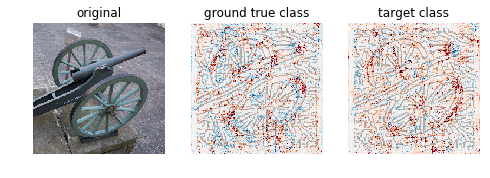

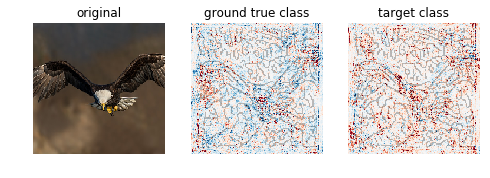

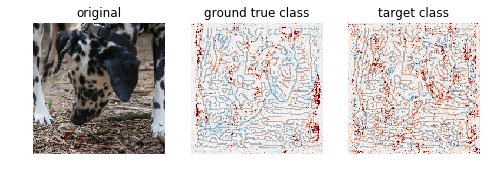

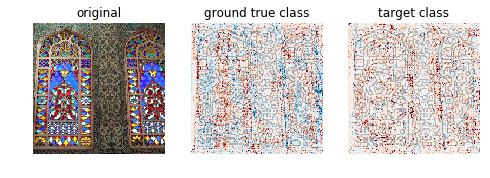

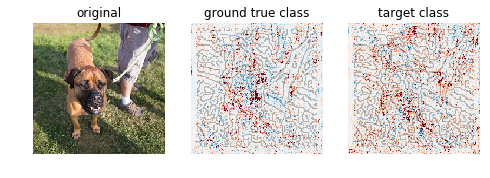

In [0]:
np.random.seed(888)
patchsize = 33
for idx in np.random.choice(np.arange(20), size=10):
    original, label = samples(dataset='imagenet', index=idx, batchsize=1, shape=(224, 224), data_format='channels_first')
    sample = imagenet_preprocess(original)
    padded_sample = pad_image(sample, patchsize)
    input = torch.from_numpy(padded_sample).to(device)
    patches = extract_patches(input, patchsize)
    compare_heatmap(pytorch_model, patches, label, np.array([463]), original)

Compare with an initial model

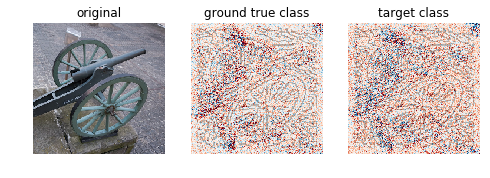

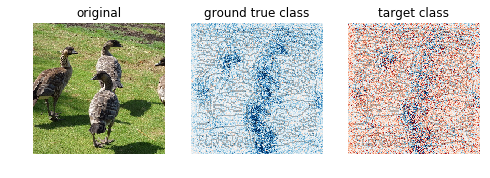

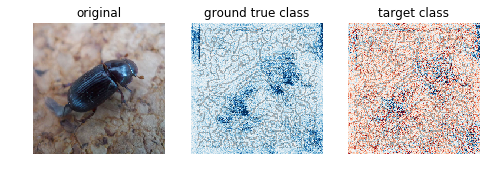

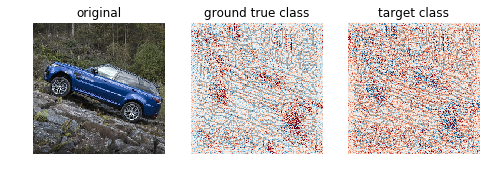

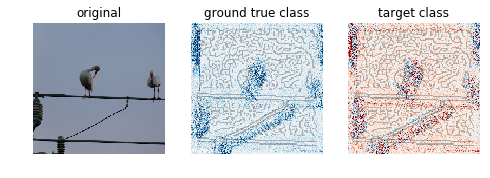

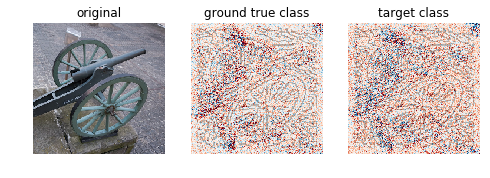

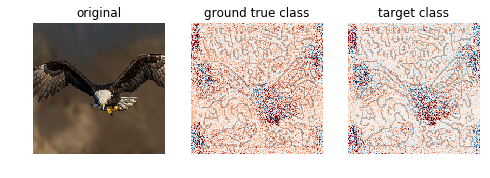

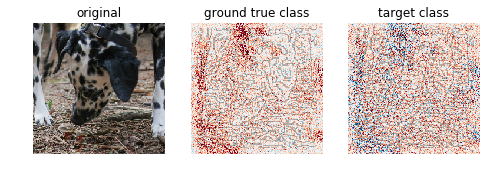

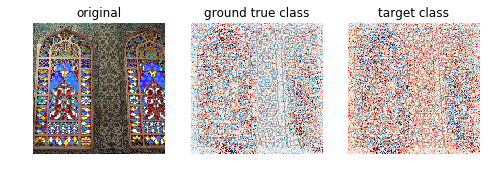

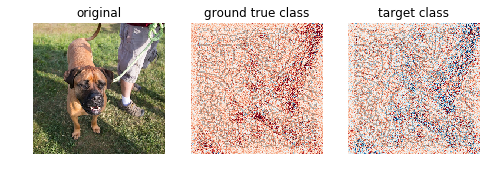

In [0]:
pytorch_model_random = bagnets.pytorch.bagnet33(pretrained=False).to(device)
np.random.seed(888)
patchsize = 33
for idx in np.random.choice(np.arange(20), size=10):
    original, label = samples(dataset='imagenet', index=idx, batchsize=1, shape=(224, 224), data_format='channels_first')
    sample = imagenet_preprocess(original)
    padded_sample = pad_image(sample, patchsize)
    input = torch.from_numpy(padded_sample).to(device)
    patches = extract_patches(input, patchsize)
    compare_heatmap(pytorch_model_random, patches, label, np.array([463]), original)